Take a look at the dataset from the 'Predicting the geographic distribution of ancient Amazonian archaeological sites with machine learning'

In [36]:
import geopandas as gpd
import pandas as pd
import os
from shapely.geometry import box
import matplotlib.pyplot as plt

In [37]:
datafile = '/Users/hereagain/Desktop/OpenAItoZ/dataset/RobertSWalker'

In [38]:
df   = pd.read_csv(f"{datafile}/submit.csv")          # your CSV
gdf  = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['x'], df['y']),
        crs="EPSG:4326")

# Simple bounding box for Parque Indígena do Xingu
#aoi  = shapely.box(-55.5, -14.5, -52.0, -11.0)       # xmin, ymin, xmax, ymax
#xin  = gdf[gdf.geometry.within(aoi)] # 33 data points 



In [39]:
xmin, ymin, xmax, ymax = -55.5, -14.5, -52.0, -11.0   
aoi = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=4326)

xin = gpd.clip(gdf, aoi)

earth = xin[xin["type"].str.contains("earthwork", case=False)] # 16
ade   = xin[xin["type"].str.contains("ADE",   case=False)] # 7
other = xin[~xin.index.isin(earth.index) & ~xin.index.isin(ade.index)] # 10 

print(f"Sites within Xingu AOI: Earthworks={len(earth)}, ADE={len(ade)}, Other={len(other)}")


Sites within Xingu AOI: Earthworks=16, ADE=7, Other=10


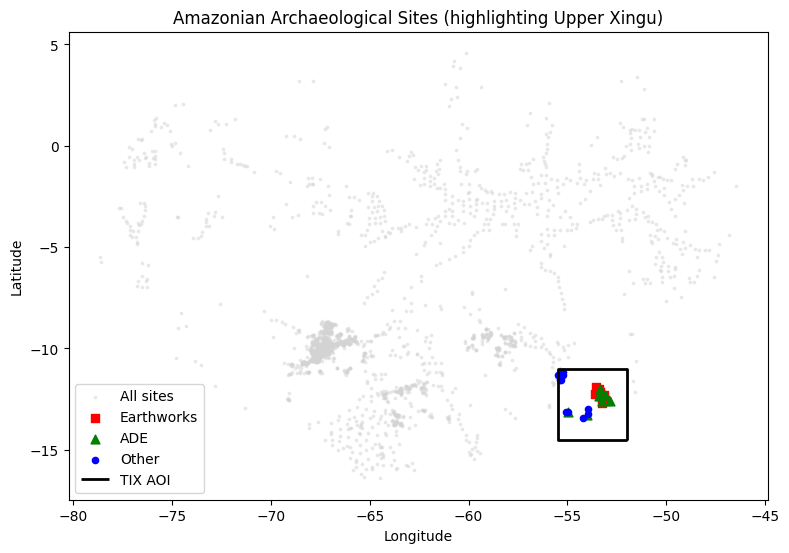

In [40]:
fig, ax = plt.subplots(figsize=(8,8))

# global backdrop
gdf.plot(ax=ax, color="lightgrey", markersize=3, alpha=0.4, label="All sites")

# upper-xingu categories
earth.plot(ax=ax, color="red",   marker="s", markersize=30, label="Earthworks")
ade.plot(  ax=ax, color="green", marker="^", markersize=40, label="ADE")
other.plot(ax=ax, color="blue",  marker="o", markersize=20, label="Other")

# AOI outline
aoi.boundary.plot(ax=ax, edgecolor="black", linewidth=2, label="TIX AOI")

ax.set_title("Amazonian Archaeological Sites (highlighting Upper Xingu)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

For better visualization

In [41]:
import pandas as pd, geopandas as gpd, folium
from shapely.geometry import box
from branca.element import MacroElement, Template
from jinja2 import Template

In [42]:
m = folium.Map(
    location=[(ymin+ymax)/2, (xmin+xmax)/2], # Center map on the Xingu AOI
    zoom_start=7, # Adjusted zoom to better fit the Xingu region
    tiles="CartoDB positron"
)

# --- 6. Add archaeological site layers to the map ---
layers = {
    "Earthworks": {"color": "#e41a1c", "data": earth, "symbol": "&#9632;"},  # red squares
    "ADE":        {"color": "#377eb8", "data": ade,   "symbol": "&#9650;"},  # blue triangles
    "Other":      {"color": "#7f7f7f", "data": other, "symbol": "&#9679;"}   # grey dots
}

for name, properties in layers.items():
    color = properties["color"]
    layer_df = properties["data"]
    # The symbol in the 'layers' dictionary is for the legend, not directly for CircleMarker
    # CircleMarker will always draw circles.
    
    fg = folium.FeatureGroup(name=name, show=name!="Other") # 'Other' layer hidden by default
    
    # Ensure there's data in the layer_df before trying to iterate
    if not layer_df.empty:
        for _, row in layer_df.iterrows():
            folium.CircleMarker(
                [row.geometry.y, row.geometry.x],
                radius=4, color=color, fill=True, fill_color=color,
                popup=name # Simple popup with layer name
            ).add_to(fg)
    else:
        print(f"No data found for {name} layer.")
    
    fg.add_to(m)

# --- 7. Add Xingu Indigenous Territory boundary or AOI rectangle ---
TIX_SHP = None # Set this to your actual shapefile path, e.g., 'path/to/xingu_indigenous_territory.shp'

if TIX_SHP:
    if os.path.exists(TIX_SHP):
        tix = gpd.read_file(TIX_SHP).to_crs(4326)
        folium.GeoJson(tix, name="Parque Indígena do Xingu",
                       style_function=lambda _: {"color":"black","weight":2,"fillOpacity":0}).add_to(m)
    else:
        print(f"Warning: TIX_SHP file not found at {TIX_SHP}. Drawing bounding box instead.")
        folium.Rectangle([[ymin, xmin],[ymax, xmax]],
                         color="black", weight=2, fill=False,
                         tooltip="Upper Xingu AOI").add_to(m)
else:
    folium.Rectangle([[ymin, xmin],[ymax, xmax]],
                     color="black", weight=2, fill=False,
                     tooltip="Upper Xingu AOI").add_to(m)

# --- 8. Add Layer Control for toggling layers ---
folium.LayerControl().add_to(m)

# --- 9. Add the custom HTML legend ---
# The HTML for the legend. Removed Jinja2 macro syntax.
legend_html = """
<div style="position: fixed;
            top: 10px; left: 50px; width: 260px; height: 72px;
            z-index: 9999; font-size: 14px; background-color: white;
            border: 2px solid grey; border-radius: 6px; padding: 6px;">
<b>Amazonian Archaeological Sites</b><br>
<font color='#377eb8'>&#9650; ADE</font>&nbsp;&nbsp;
<font color='#e41a1c'>&#9632; Earthwork</font>&nbsp;&nbsp;
<font color='#7f7f7f'>&#9679; Other</font>
</div>
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)



### Full look at the whole map 
here I wanna plot over all ADE, earthworks and Other types sites on the map

In [43]:
earth = gdf[gdf["type"].str.contains("earthwork", case=False)]
ade   = gdf[gdf["type"].str.contains("ADE",   case=False)]
other = gdf[~gdf.index.isin(earth.index) & ~gdf.index.isin(ade.index)]

print(f"Total sites: Earthworks={len(earth)}, ADE={len(ade)}, Other={len(other)}")


Total sites: Earthworks=1253, ADE=455, Other=373


In [44]:
center_lat = gdf.geometry.y.mean()
center_lon = gdf.geometry.x.mean()
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
zoom_level = 3
# resrtrct to South America only 
sa_center_lat = -15.0
sa_center_lon = -60.0
sa_zoom_start = 4

In [45]:
# m = folium.Map(
#     location=[center_lat, center_lon],
#     zoom_start=zoom_level,
#     tiles="CartoDB positron" # Clean, publication-friendly basemap
# )
m = folium.Map(
    location=[sa_center_lat, sa_center_lon],
    zoom_start=sa_zoom_start,
    tiles="CartoDB positron" # Clean, publication-friendly basemap
)

# --- 5. Add archaeological site layers to the map ---
# We'll use CircleMarkers for all points. Legend will reflect this.
layers = {
    "Earthworks": {"color": "#e41a1c", "data": earth},  # red
    "ADE":        {"color": "#377eb8", "data": ade},   # blue
    "Other":      {"color": "#7f7f7f", "data": other}   # grey
}

for name, properties in layers.items():
    color = properties["color"]
    layer_df = properties["data"]
    
    # 'Other' layer is hidden by default in the LayerControl for cleaner initial view
    fg = folium.FeatureGroup(name=name, show=name!="Other") 
    
    if not layer_df.empty:
        for _, row in layer_df.iterrows():
            folium.CircleMarker(
                [row.geometry.y, row.geometry.x],
                radius=5, # Slightly larger radius for better visibility
                color=color, fill=True, fill_color=color, fill_opacity=0.8,
                weight=1, # Thin border for clarity
                popup=name # Simple popup with layer name
            ).add_to(fg)
    else:
        print(f"No data found for {name} layer.")
    
    fg.add_to(m)

In [46]:
xingu_xmin, xingu_ymin, xingu_xmax, xingu_ymax = -55.5, -14.5, -52.0, -11.0
folium.Rectangle([[xingu_ymin, xingu_xmin],[xingu_ymax, xingu_xmax]],
                 color="orange", weight=2, fill=False,
                 tooltip="Upper Xingu AOI").add_to(m)


folium.LayerControl().add_to(m)

# --- 8. Add the custom HTML legend (updated to show circles) ---
legend_html = """
<div style="position: fixed;
            bottom: 20px; left: 20px; width: 160px; height: 100px;
            z-index: 9999; font-size: 14px; background-color: white;
            border: 2px solid grey; border-radius: 6px; padding: 6px;">
<b>Site Types</b><br>
<i style="background:#377eb8; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> ADE<br>
<i style="background:#e41a1c; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> Earthwork<br>
<i style="background:#7f7f7f; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> Other
</div>
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

In [47]:
m

In [50]:
south_america_bounds = [
    [-56.0, -82.0],  # SW corner (approx southern Chile/Argentina, western Peru)
    [15.0, -32.0]    # NE corner (approx northern Venezuela/Guyana, eastern Brazil)
]
sa_zoom_start = 4

m = folium.Map(
    location=[(south_america_bounds[0][0] + south_america_bounds[1][0]) / 2,
              (south_america_bounds[0][1] + south_america_bounds[1][1]) / 2],
    zoom_start=sa_zoom_start,
    tiles="CartoDB positron", # Clean, publication-friendly basemap
    min_lat=south_america_bounds[0][0],
    max_lat=south_america_bounds[1][0],
    min_lon=south_america_bounds[0][1],
    max_lon=south_america_bounds[1][1],
    # You can also set max_bounds_zoom=sa_zoom_start to prevent zooming out further than this view
    max_bounds_zoom=sa_zoom_start
)

# --- 5. Add archaeological site layers to the map ---
layers = {
    "Earthworks": {"color": "#e41a1c", "data": earth},  # red
    "ADE":        {"color": "#377eb8", "data": ade},   # blue
    "Other":      {"color": "#7f7f7f", "data": other}   # grey
}

for name, properties in layers.items():
    color = properties["color"]
    layer_df = properties["data"]
    
    fg = folium.FeatureGroup(name=name, show=name!="Other") 
    
    if not layer_df.empty:
        for _, row in layer_df.iterrows():
            folium.CircleMarker(
                [row.geometry.y, row.geometry.x],
                radius=5, # Slightly larger radius for better visibility
                color=color, fill=True, fill_color=color, fill_opacity=0.8,
                weight=1, # Thin border for clarity
                popup=name
            ).add_to(fg)
    else:
        print(f"No data found for {name} layer.")
    
    fg.add_to(m)

# --- 6. Add Layer Control for toggling layers ---
folium.LayerControl().add_to(m)

xingu_xmin, xingu_ymin, xingu_xmax, xingu_ymax = -55.5, -14.5, -52.0, -11.0



# Create a FeatureGroup for the Xingu boundary to allow toggling it
fg_xingu = folium.FeatureGroup(name="Upper Xingu Region", show=True) # Show by default
folium.Rectangle([[xingu_ymin, xingu_xmin],[xingu_ymax, xingu_xmax]],
                 color="orange", weight=2, fill=False,
                 tooltip="Upper Xingu AOI").add_to(m)


folium.LayerControl().add_to(m)

fg_xingu.add_to(m) # Add the Xingu feature group to the map


# --- 8. Add the custom HTML legend ---
legend_html = """
<div style="position: fixed;
            bottom: 20px; left: 20px; width: 160px; height: 100px;
            z-index: 9999; font-size: 14px; background-color: white;
            border: 2px solid grey; border-radius: 6px; padding: 6px;">
<b>Site Types</b><br>
<i style="background:#377eb8; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> ADE<br>
<i style="background:#e41a1c; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> Earthwork<br>
<i style="background:#7f7f7f; width:10px; height:10px; border-radius:50%; display:inline-block; margin-right:5px;"></i> Other
</div>
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# --- 9. Fit bounds to all archaeological data points ---
# This ensures ALL your data points are visible within the current South American view.
# It should make sure the map zooms to fit all sites within the SA context.
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])


# --- 10. Display the map ---
m